Without expert knowledge, machine learning in practical settings is difficult to understand and apply especially for novices, it requires a lot of time and resources. This task can be considerably automated to make it easier using the free Python AutoML library.


What is AutoML and how is it used in Python?

How to use popular and well-known Python AutoML libraries:

- H2O

- TPOT

- PyCaret

- AutoGluon

- Auto-sklearn

We will evaluate each AutoML tool on a time series dataset as an example in order to identify efficient model pipelines in Python.

Data can be found here: https://archive.ics.uci.edu/ml/machine-learning-databases/00235/

# **H2O**

**Preprocess the Example dataset**

We will use a dataset of individual household electricity consumption. A time-series record of household electricity consumption from 2006 to 2010.

In [1]:
import pandas as pd

# load the dataset
df = pd.read_csv('household_power_consumption.txt', delimiter=';', low_memory=False)

# grab time series of electricity usage
df['date_time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df['electricity_usage'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df = df[['date_time', 'electricity_usage']].copy()

# set the index as and sort by date and time
df = df.set_index('date_time').sort_index()

# resample to hourly frequency
df_hour = df.resample('1H').mean()

# create shifted time series
df_hour['electricity_usage'] = df_hour['electricity_usage'].fillna(method='ffill')
for i in range(1,9):
  string_column = 'electricity_usage_'+str(i)+'hr_lag'
  df_hour[string_column] = df_hour['electricity_usage'].shift(i)

# create month/seasonality as a feature
df_hour['month'] = df_hour.index.month

# drop missing data
df_hour = df_hour.dropna()

# split train test sets
sample_size = df_hour.shape[0] - 200
df_train = df_hour.iloc[:sample_size].copy()
df_test = df_hour.iloc[sample_size:].copy()

In [3]:
!pip install h2o

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 MB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.40.0.2-py2.py3-none-any.whl size=177693439 sha256=5554cd7822a5ed595c740201546086448604fd7289075303be4ec65748d73c19
  Stored in directory: /root/.cache/pip/wheels/b2/79/e3/842b81607eb31946ee24898cc9961b101e6486f988a5103967
Successfully built h2o


In [4]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.18" 2023-01-17; OpenJDK Runtime Environment (build 11.0.18+10-post-Ubuntu-0ubuntu120.04.1); OpenJDK 64-Bit Server VM (build 11.0.18+10-post-Ubuntu-0ubuntu120.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.9/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpt0wlkjfg
  JVM stdout: /tmp/tmpt0wlkjfg/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpt0wlkjfg/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.2
H2O_cluster_version_age:,"21 days, 10 hours and 51 minutes"
H2O_cluster_name:,H2O_from_python_unknownUser_fwbjfr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.172 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [5]:
h2o_frame = h2o.H2OFrame(df_train)
x = h2o_frame.columns
y = 'electricity_usage'
x.remove(y)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [6]:
h2o_automl = H2OAutoML(sort_metric='mse', max_runtime_secs=50*60, seed=666)
h2o_automl.train(x=x, y=y, training_frame=h2o_frame)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),30/149
# GBM base models (used / total),14/90
# XGBoost base models (used / total),13/51
# DRF base models (used / total),1/2
# DeepLearning base models (used / total),1/5
# GLM base models (used / total),1/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5


In [7]:
h2o_models = h2o.automl.get_leaderboard(h2o_automl, extra_columns = "ALL")
h2o_models

model_id,mse,rmse,mae,rmsle,mean_residual_deviance,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_AllModels_3_AutoML_1_20230331_20845,0.35793,0.598273,0.407897,0.248623,0.35793,10434,0.372159,StackedEnsemble
StackedEnsemble_AllModels_4_AutoML_1_20230331_20845,0.358039,0.598364,0.408075,0.248652,0.358039,10835,0.213432,StackedEnsemble
StackedEnsemble_BestOfFamily_3_AutoML_1_20230331_20845,0.358647,0.598871,0.409041,0.248963,0.358647,1137,0.086794,StackedEnsemble
StackedEnsemble_AllModels_1_AutoML_1_20230331_20845,0.358702,0.598917,0.409026,0.248829,0.358702,1128,0.063188,StackedEnsemble
StackedEnsemble_AllModels_2_AutoML_1_20230331_20845,0.358753,0.59896,0.408945,0.24896,0.358753,1573,0.09267,StackedEnsemble
StackedEnsemble_BestOfFamily_4_AutoML_1_20230331_20845,0.358879,0.599065,0.408972,0.249051,0.358879,1251,0.055147,StackedEnsemble
StackedEnsemble_BestOfFamily_2_AutoML_1_20230331_20845,0.359007,0.599172,0.409716,0.248979,0.359007,690,0.036415,StackedEnsemble
StackedEnsemble_BestOfFamily_1_AutoML_1_20230331_20845,0.359853,0.599878,0.411055,0.24943,0.359853,816,0.015828,StackedEnsemble
GBM_1_AutoML_1_20230331_20845,0.360417,0.600347,0.411374,0.249783,0.360417,2907,0.015425,GBM
StackedEnsemble_BestOfFamily_5_AutoML_1_20230331_20845,0.360911,0.600759,0.409847,0.24929,0.360911,9788,0.093535,StackedEnsemble


In [8]:
from h2o.model.regression import h2o_mean_squared_error

h2o_frame_test = h2o.H2OFrame(df_test)

y_pred = h2o_automl.predict(h2o_frame_test)
y_actual = h2o.H2OFrame(df_test[['electricity_usage']])

h2o_mean_squared_error(y_actual, y_pred)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


0.3016363499628232

<Axes: xlabel='date_time'>

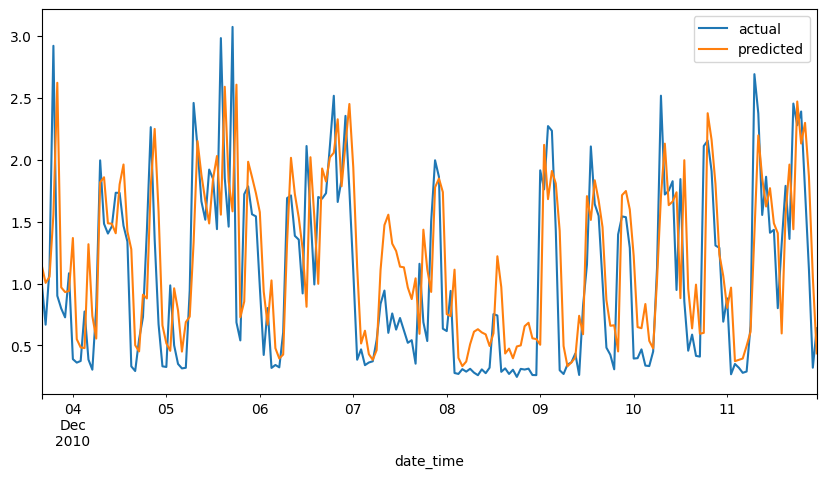

In [9]:
h2o_compare = pd.DataFrame(data={'actual': df_test['electricity_usage'], 'predicted': y_pred.as_data_frame().to_numpy().ravel()})
h2o_compare.plot(figsize=(10, 5))

# **TPOT**

TPOT (Tree-based Pipeline Optimizer Tool) is a Python automated machine learning tool based on the popular machine learning package scikit-learn. Automate processes such as feature engineering, model selection, and parameter optimization. This tool follows a technique called genetic programming. It applies manipulations that mimic natural genetic processes to develop programs. 

TPOT is designed in a similar way to scikit-learn, so if you are familiar with scikit-learn you may find it easier to use.

First, since this is a regression problem, we create an instance of the TPOTRegressor class. Within the arguments, set some parameters.


Generation=100 and population size=100:
These two parameters are related to genetic programming. In general, the higher these numbers, the better TPOT performance.

Verbosity=1:
This determines how much information he TPOT outputs during execution. score='neg_mean_squared_error':
This is a feature used to assess pipeline quality. Use negative mean squared error, which is negative MSE.

max_time_mins=30: Limit TPOT optimization time to 30 minutes

Random State = 666:
Sets the seed of the pseudo-random number generator for reproducibility 

In [10]:
!pip install tpot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 KB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 KB 18.2 MB/s eta 0:00:00
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11954 sha256=b79be94fc7d42d2c13e99ef19d74a628262af864082ef3065ff2d3d263acd356
  Stored in directory: /root/.cache/pip/wheels/48/8c/93/3afb1916772591fe6bcc25cdf8b1c5bdc362f0ec8e2f0fd413
Successfully built stopit


In [11]:
from tpot import TPOTRegressor

tpot_automl = TPOTRegressor(generations=100, population_size=100, 
                            verbosity=1, scoring='neg_mean_squared_error',   
                            max_time_mins=30, random_state = 666)

In [12]:
X_train = df_train.drop(columns='electricity_usage')
y_train = df_train['electricity_usage']

In [13]:
tpot_automl.fit(X_train, y_train)


30.73 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.
Best pipeline: ExtraTreesRegressor(input_matrix, bootstrap=True, max_features=1.0, min_samples_leaf=11, min_samples_split=17, n_estimators=100)


TPOTRegressor(max_time_mins=30, random_state=666,
              scoring='neg_mean_squared_error', verbosity=1)

We can already see the best pipeline from the result above. But we can also export the optimized pipeline as Python code.

In [14]:
tpot_automl.export('tpot_best_model.py')

Calculate metrics
We can also evaluate the pipeline using the test set.

In [15]:
X_test = df_test.drop(columns='electricity_usage')
y_test = df_test['electricity_usage']

tpot_automl.score(X_test, y_test)

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_scorer.py:794: FutureWarning: sklearn.metrics.SCORERS is deprecated and will be removed in v1.3. Please use sklearn.metrics.get_scorer_names to get a list of available scorers and sklearn.metrics.get_metric to get scorer.
  warnings.warn(


-0.2939878241134443

We’ve set the score as the negative MSE. The MSE would be the positive part of this number below.



In [16]:
from sklearn.metrics import mean_squared_error

y_pred = tpot_automl.predict(X_test)
mean_squared_error(y_test, y_pred)

0.2939878241134443

Plot predicted and actual data comparisons
In the end, let’s also plot the comparison of the prediction and actual data of the test set.

<Axes: xlabel='date_time'>

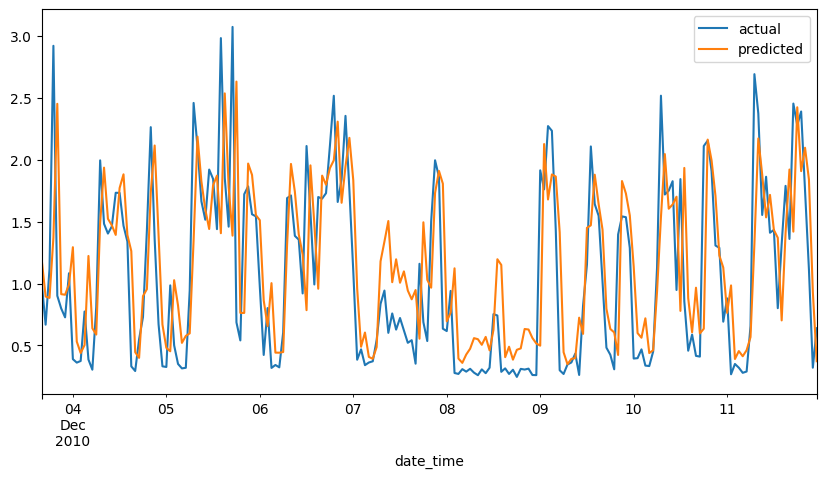

In [17]:
tpot_compare = pd.DataFrame(data={'actual': df_test['electricity_usage'], 'predicted': y_pred})
tpot_compare.plot(figsize=(10, 5))

# **PyCaret**

PyCaret is a Python library that automates machine learning workflows. It is based on other Python machine learning libraries such as scikit-learn, XGBoost and LightGBM. The library is primarily aimed at citizen data scientists who prefer low-code, but it is also intended for other data science users. PyCaret can be used for both supervised and unsupervised learning. 

Use PyCaret's Regression module to train the dataset. PyCaret also has a time series module. 

First, we will set up training environment and create a transform pipeline. Within the arguments, set the session_id parameter for reproducibility. 

In [18]:
!pip install pycaret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.8/481.8 KB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 86.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 KB 18.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 85.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.8/105.8 KB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 KB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46

In [19]:
from pycaret.regression import setup, compare_models, predict_model
pycaret_automl = setup(data=df_train, target = 'electricity_usage', session_id=666)

,Description,Value
0,Session id,666
1,Target,electricity_usage
2,Target type,Regression
3,Original data shape,"(34743, 10)"
4,Transformed data shape,"(34743, 10)"
5,Transformed train set shape,"(24320, 10)"
6,Transformed test set shape,"(10423, 10)"
7,Numeric features,9
8,Preprocess,True
9,Imputation type,simple


When the setup function is run, PyCaret automatically infers the data types in our dataset. So we can see that the columns in the dataset are printed with derived data types. If they are correct, we can press enter to continue. If not, they can be specified using the numeric_features, categorical_features, and date_features parameters in the setup function. 

Then the process is started and a summary is printed. I won't introduce it because it's long.

Then you can use the compare_models function to train and evaluate model performance based on cross-validation. Set two parameters in that argument.


sort='MSE':
Sets the MSE (mean squared error) as the sorting criterion for the results
budget_time=30:
Set timeout to 30 minutes 

In [20]:
pycaret_models = compare_models(sort='MSE', budget_time=30)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.4161,0.3650,0.6040,0.5349,0.2524,0.5598,0.5530
gbr,Gradient Boosting Regressor,0.4194,0.3663,0.6050,0.5334,0.2536,0.5715,5.2720
rf,Random Forest Regressor,0.4232,0.3737,0.6111,0.5240,0.2570,0.5828,18.7800
et,Extra Trees Regressor,0.4255,0.3771,0.6140,0.5195,0.2577,0.5869,5.4260
xgboost,Extreme Gradient Boosting,0.4278,0.3865,0.6215,0.5077,0.2600,0.5706,3.6460
ridge,Ridge Regression,0.4450,0.3883,0.6230,0.5052,0.2621,0.6427,0.0620
br,Bayesian Ridge,0.4450,0.3883,0.6230,0.5052,0.2621,0.6429,0.0390
lr,Linear Regression,0.4450,0.3883,0.6230,0.5052,0.2621,0.6427,0.3910
lar,Least Angle Regression,0.4450,0.3886,0.6233,0.5047,0.2622,0.6424,0.0390
omp,Orthogonal Matching Pursuit,0.4469,0.3925,0.6264,0.4998,0.2642,0.6453,0.0400


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

Print best performing model(s)
To look at the best-performing model, we can print it out.

In [21]:
print(pycaret_models)

LGBMRegressor(random_state=666)


Calculate metrics
To calculate the MSE metric on the test set, we can use the mean_squared_error function from sklearn.

In [22]:
from sklearn.metrics import mean_squared_error

predictions = predict_model(pycaret_models, data=df_test)
mean_squared_error(predictions['electricity_usage'], predictions['prediction_label'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.4115,0.2940,0.5422,0.4169,0.2491,0.5888


0.2940108100531581

Plot predicted and actual data comparisons
And lastly, let’s also plot to compare the actual and predicted data.

<Axes: xlabel='date_time'>

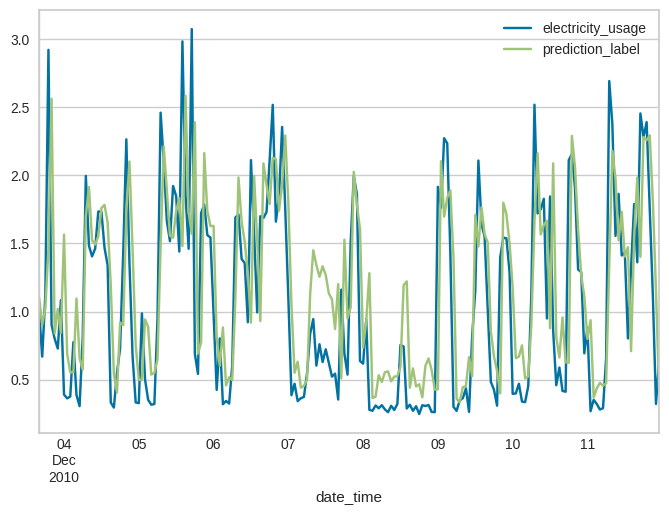

In [23]:
predictions[['electricity_usage', 'prediction_label']].plot()

# **AutoGluon**

AutoGluon is an AutoML tool that works not only on tabular data, but also text and images. It focuses on automated stack ensembles, deep learning, and more. It seems to only cover supervised learning issues.

This example uses the tabular module. Inside the TabularPredictor, we set the eval_metric to mean squared error. Then we can use the fitting function to train the model using AutoGluon. Also we set the time_limit to 30 minutes. 

In [24]:
!pip install autogluon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.7/108.7 KB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.3/218.3 KB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.1/331.1 KB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.2/292.2 KB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 KB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 KB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 KB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 KB 30.9 MB/s eta 0:00:00
  Installing bui

In [25]:
from autogluon.tabular import TabularPredictor
autogluon_automl = TabularPredictor(label='electricity_usage', problem_type='regression', eval_metric='mean_squared_error')
autogluon_automl.fit(train_data=df_train, time_limit=50*60)

No path specified. Models will be saved in: "AutogluonModels/ag-20230331_034023/"
Beginning AutoGluon training ... Time limit = 3000s
AutoGluon will save models to "AutogluonModels/ag-20230331_034023/"
AutoGluon Version:  0.7.0
Python Version:     3.9.16
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sat Dec 10 16:00:40 UTC 2022
Train Data Rows:    34743
Train Data Columns: 9
Label Column: electricity_usage
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    7766.15 MB
	Train Data (Original)  Memory Usage: 2.5 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4

Print best performing model(s)
We can use the leaderboard function to see the models and their information.

In [26]:
autogluon_automl.leaderboard()

                  model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2  -0.347970       0.570276  173.646331                0.000729           0.492404            2       True         12
1            LightGBMXT  -0.349733       0.117132    2.439905                0.117132           2.439905            1       True          3
2              LightGBM  -0.351415       0.026242    1.002305                0.026242           1.002305            1       True          4
3              CatBoost  -0.353329       0.002618    2.845950                0.002618           2.845950            1       True          6
4               XGBoost  -0.353716       0.018108    1.015093                0.018108           1.015093            1       True          9
5         LightGBMLarge  -0.354953       0.064240    3.133070                0.064240           3.133070            1       True         11
6       NeuralNetFas

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-0.347970,0.570276,173.646331,0.000729,0.492404,2,True,12
1,LightGBMXT,-0.349733,0.117132,2.439905,0.117132,2.439905,1,True,3
2,LightGBM,-0.351415,0.026242,1.002305,0.026242,1.002305,1,True,4
3,CatBoost,-0.353329,0.002618,2.845950,0.002618,2.845950,1,True,6
4,XGBoost,-0.353716,0.018108,1.015093,0.018108,1.015093,1,True,9
5,LightGBMLarge,-0.354953,0.064240,3.133070,0.064240,3.133070,1,True,11
6,NeuralNetFastAI,-0.355341,0.035902,34.403775,0.035902,34.403775,1,True,8
7,ExtraTreesMSE,-0.361668,0.256638,16.832206,0.256638,16.832206,1,True,7
8,RandomForestMSE,-0.364304,0.287799,106.654495,0.287799,106.654495,1,True,5
9,NeuralNetTorch,-0.366420,0.020124,24.505285,0.020124,24.505285,1,True,10


Calculate metrics
We can use the evaluate function to see the metrics for our test set.

In [27]:
autogluon_automl.evaluate(df_test)

Evaluation: mean_squared_error on test data: -0.2981312193266357
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "mean_squared_error": -0.2981312193266357,
    "root_mean_squared_error": -0.54601393693443,
    "mean_absolute_error": -0.41254974844998826,
    "r2": 0.4087412519372854,
    "pearsonr": 0.6852552677735513,
    "median_absolute_error": -0.30583646163940437
}


{'mean_squared_error': -0.2981312193266357,
 'root_mean_squared_error': -0.54601393693443,
 'mean_absolute_error': -0.41254974844998826,
 'r2': 0.4087412519372854,
 'pearsonr': 0.6852552677735513,
 'median_absolute_error': -0.30583646163940437}

Plot predicted and actual data comparisons
And we can also plot to compare the actual and predicted values.

<Axes: xlabel='date_time'>

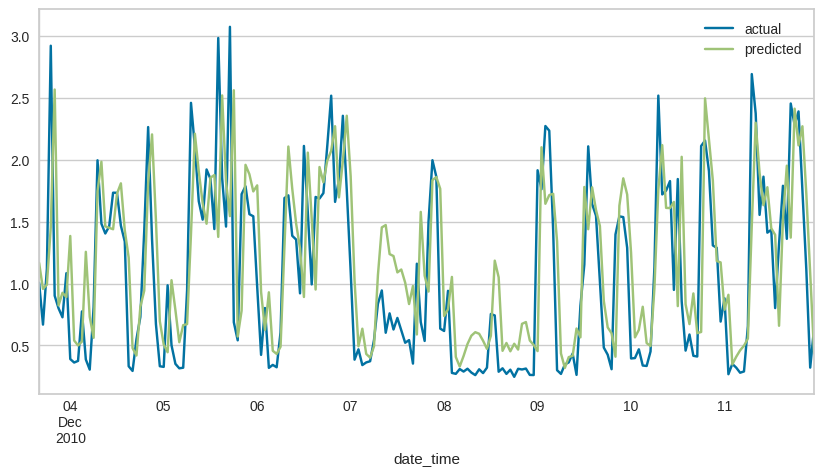

In [28]:
y_pred = autogluon_automl.predict(df_test)
autogluon_compare = pd.DataFrame(data={'actual': df_test['electricity_usage'], 'predicted': y_pred})
autogluon_compare.plot(figsize=(10, 5))

# **Auto-sklearn**

In [31]:
!pip3 install --upgrade pip 
!pip install auto-sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 22.0.4
    Uninstalling pip-22.0.4:
      Successfully uninstalled pip-22.0.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-multimodal 0.7.0 requires scikit-learn<1.3,>=1.0, but you have scikit-learn 0.24.2 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [33]:
from pprint import pprint
import autosklearn.regression
automl = autosklearn.regression.AutoSklearnRegressor(time_left_for_this_task=1800)
automl.fit(X_train, y_train)
predictions = automl.predict(X_test)
mean_squared_error(y_test, predictions)

[WARNING] [2023-03-31 03:48:21,499:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2023-03-31 03:48:28,526:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2023-03-31 03:48:32,602:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2023-03-31 03:48:37,080:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2023-03-31 03:49:13,667:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2023-03-31 03:49:15,411:Client-EnsembleBuilder] No runs were available to build an ensemble from


0.2826382313721723

In [34]:
print(automl.leaderboard())

          rank  ensemble_weight                 type      cost   duration
model_id                                                                 
105          1             0.02  k_nearest_neighbors  0.471286   2.617048
95           2             0.14  k_nearest_neighbors  0.474998   3.466580
79           3             0.10        liblinear_svr  0.478623   0.946105
98           4             0.04  k_nearest_neighbors  0.479865   3.534182
61           5             0.08  k_nearest_neighbors  0.483326   3.204168
48           6             0.10  k_nearest_neighbors  0.487163   1.733493
127          7             0.10             adaboost  0.490723  13.530173
76           8             0.02  k_nearest_neighbors  0.494339   8.328973
88           9             0.14        decision_tree  0.496739   1.551318
90          10             0.04  k_nearest_neighbors  0.500370   1.555969
52          11             0.12  k_nearest_neighbors  0.501903   7.526629
102         12             0.04  k_nea

In [35]:
import sklearn
train_predictions = automl.predict(X_train)
print("Train R2 score:", sklearn.metrics.r2_score(y_train, train_predictions))
print("Test R2 score:", sklearn.metrics.r2_score(y_test, predictions))

Train R2 score: 0.7263274923963985
Test R2 score: 0.439467201008961


**Print the final ensemble constructed by auto-sklearn**

In [36]:
pprint(automl.show_models(), indent=4)

{   48: {   'cost': 0.4871626264427922,
            'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice object at 0x7f78b22bf4c0>,
            'ensemble_weight': 0.1,
            'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice object at 0x7f78b2030ee0>,
            'model_id': 48,
            'rank': 1,
            'regressor': <autosklearn.pipeline.components.regression.RegressorChoice object at 0x7f78b2030340>,
            'sklearn_regressor': KNeighborsRegressor(n_neighbors=17, weights='distance')},
    52: {   'cost': 0.5019027978524685,
            'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice object at 0x7f78b0f28c10>,
            'ensemble_weight': 0.12,
            'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice object at 0x7f78b1072be0>,
            'model_id': 52,
       

**Plot the predictions**

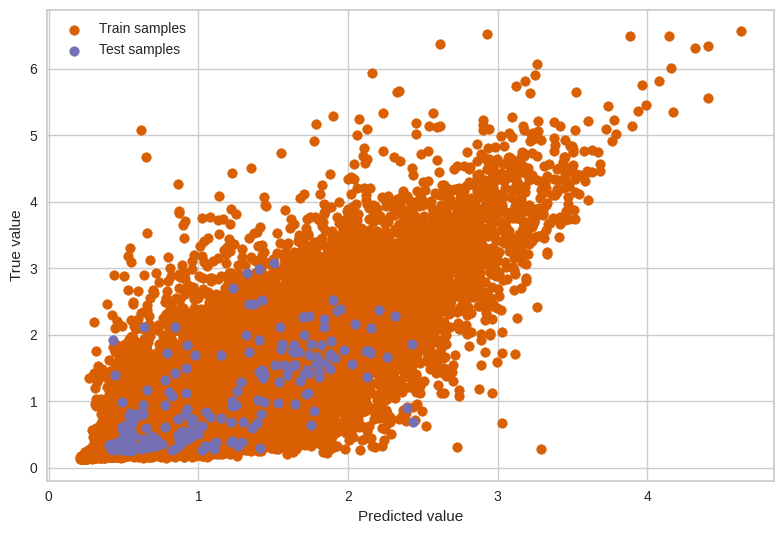

In [38]:
import matplotlib.pyplot as plt
plt.scatter(train_predictions, y_train, label="Train samples", c="#d95f02")
plt.scatter(predictions, y_test, label="Test samples", c="#7570b3")
plt.xlabel("Predicted value")
plt.ylabel("True value")
plt.legend()
plt.tight_layout()
plt.show()